In [1]:
!pip install transformers torch torchaudio datasets librosa

### **Notebook overview**

In this notebook, we prepare the dataset with all relevant embedding vectors and other acoustic and prosodic features to do audio sentiment classification for our chosen dataset.

In [2]:
from datasets import load_dataset
import librosa
import io
import numpy as np
import torch

### **Dataset description**

10,000 audio samples representing 8 different emotions spoken by speakers of diverse age group. The dataset consists of audio samples spoken by both male and female speakers. The 8 emotion classes are "sad", "fear", "distress", "anger", "happy", "neutral" and "surprised". The audio format is raw bytes.

Link to dataset : [stapesai/ssi-speech-emotion-recognition-dataset](https://huggingface.co/datasets/stapesai/ssi-speech-emotion-recognition#dataset-card-for-ssi-speech-emotion-recognition---stapes-ai)

In [3]:
data = load_dataset("stapesai/ssi-speech-emotion-recognition")

README.md:   0%|          | 0.00/6.26k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/373M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/374M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/374M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1999 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/163 [00:00<?, ? examples/s]

### **Data Preprocessing steps**

1. Convert raw audio bytes into numerical format in the form of tensors.
2. Extract sample rate for each audio sample.
3. Map emotion classes to numerical labels.
4. Resample audio samples into uniform sample rate of 16000 Hz.
5. Pad or trucate the audio sample to maintain a uniform duration of 3 seconds.


In [4]:
# pad or truncate

def pad_or_truncate(waveform, max_length = 48000):

  """
   This function pads or truncates the audio sample such that each audio
   sample has the uniform length of 3 seconds.
  """
  
  num_samples = waveform.shape[0]
  waveform = torch.tensor(waveform).unsqueeze(0)

  if num_samples < max_length:  # Pad shorter audio
      pad = torch.zeros((1, max_length - num_samples))
      waveform = torch.cat((waveform, pad), dim=1)
  elif num_samples > max_length:  # Truncate longer audio
      waveform = waveform[:, :max_length]

  return waveform


# formatting the dataset

def format_data(df):

  """
    This function formats the dataset.
    
    -> Converts audio samples from raw audio bytes to numerical waveforms.
    -> Extracts the sample rate of samples.
    -> Maps string sentiment labels to numerical sentiment labels.
  """
    
  df["audio_bytes"] =  df["file_path"].apply(lambda x: x["bytes"])
  df["waveform"], df["sample_rate"] = zip(*df["audio_bytes"].apply(
        lambda x: librosa.load(io.BytesIO(x), sr=None)
    ))
  label_mapping = {
        "ANG": 0, "FEA": 1, "SAD": 2, "DIS": 3,
        "SUR": 4, "HAP": 5, "CAL": 6, "NEU": 7
    }
  df["label"] = df["emotion"].apply(lambda x: label_mapping[x])
  df = df[["waveform", "sample_rate", "label"]]

  return df

# feature engineering

def feature_engineering(data):

  """
    This functions defines additional features to the dataset.

    -> "Length" depicts the length of overall length of the waveform. (Should be 48000.
    Sampled at 16000 Hz and 3 seconds long).
  """
    
  data["length"] = data["waveform"].apply(lambda x: len(x[0]))
  return data

# resampling data
def resample_data(data):

  """
    This function resamples the audio sample to 16000 Hz.
  """
    
  data["waveform"] = data.apply(
    lambda row: librosa.resample(np.array(row["waveform"]), orig_sr=row["sample_rate"], target_sr=16000),
    axis=1
  )
  data["sample_rate"] = data["sample_rate"].apply(lambda x: 16000)
  data["waveform"] = data["waveform"].apply(pad_or_truncate)

  return data

# preprocessing data

def preprocess_dataset(df, set_):

  """
  This function applies the overall preprocessing pipeline to each audio sample.
  """
    
  data = df[set_].to_pandas()
  data = format_data(data)
  data = resample_data(data)
  data = feature_engineering(data)
  return data

In [5]:
data_train = preprocess_dataset(data, "train")
data_val = preprocess_dataset(data, "validation")

### **Extracting embedding vectors**

Here, I have chosen three speech models : Hubert base, Word2vec base and Whisper base to extract the embedding vector from the last hidden state. The ideas is to build a classification model on top of these embedding vectors to classify sentiments. The embedding vectors will have an indepth understanding of speakers traits, phonetics and accent.

**Model links:**

1. Hubert base - [Link](https://huggingface.co/facebook/hubert-base-ls960)
2. Word2vec base - [Link](https://huggingface.co/facebook/wav2vec2-base)
3. Whisper base - [Link](https://huggingface.co/openai/whisper-base)

This notebook will cover sentiment classification using Hubert and Wav2vec

In [6]:
from transformers import AutoModel, AutoFeatureExtractor
from transformers import WhisperProcessor

hubert_model_name = "facebook/hubert-base-ls960"
hubert = AutoModel.from_pretrained(hubert_model_name)
hubert_feature_extractor = AutoFeatureExtractor.from_pretrained(hubert_model_name)

wav2vec_model_name = "facebook/wav2vec2-base"
wav2vec = AutoModel.from_pretrained(wav2vec_model_name)
wav2vec_feature_extractor = AutoFeatureExtractor.from_pretrained(wav2vec_model_name)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

In [7]:
# Extracting sample feature vector for each model

hubert_features = hubert_feature_extractor(data_train["waveform"][0].squeeze(0), sampling_rate=16000, return_tensors="pt")
wav2vec_features = wav2vec_feature_extractor(data_train["waveform"][0].squeeze(0), sampling_rate=16000, return_tensors="pt")

# Printing one sample feature vector for each model along with their shapes

print(f"Hubert feature :\n\n{hubert_features}\n\nShape : {hubert_features['input_values'].shape}")
print(f"\nWav2vec features :\n\n{wav2vec_features}\n\nShape : {wav2vec_features['input_values'].shape}")


Hubert feature :

{'input_values': tensor([[0.1294, 0.1294, 0.1469,  ..., 0.0010, 0.0010, 0.0010]])}

Shape : torch.Size([1, 48000])

Wav2vec features :

{'input_values': tensor([[0.1294, 0.1294, 0.1469,  ..., 0.0010, 0.0010, 0.0010]])}

Shape : torch.Size([1, 48000])


In [8]:
import pandas as pd

# Merging train and validation datasets

data_train["split"] = "train"
data_val["split"] = "validation"
data = pd.concat([data_train, data_val], ignore_index=True)

In [9]:
data["hubert_features"] = data["waveform"].apply(lambda x: hubert_feature_extractor(x.squeeze(0), sampling_rate=16000, return_tensors="pt")["input_values"])
data["wav2vec_features"] = data["waveform"].apply(lambda x: wav2vec_feature_extractor(x.squeeze(0), sampling_rate=16000, return_tensors="pt")["input_values"])

In [10]:
# Extracting embeddings from Hubert and Wav2vec base models
 
def get_embeddings(feature, model):
  global count, device
  count += 1

  feature = feature.to(device)  
  with torch.no_grad():
      outputs = model(feature)

  embeddings = outputs.last_hidden_state

  if count%500 == 0:
      print(f"Embeddings stored  : {count}/{len(data)}")

  return embeddings

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
hubert_model = hubert.to(device)
wav2vec_model = wav2vec.to(device)

count = 0
print("Extracting Hubert embeddings :\n\n")
data["hubert_embeddings"] = data["hubert_features"].apply(lambda x : get_embeddings(x, hubert_model))

count = 0
print("\n\nExtracting Wav2vec embeddings :\n")
data["wav2vec_embeddings"] = data["wav2vec_features"].apply(lambda x : get_embeddings(x, wav2vec_model))

Extracting Hubert embeddings :


Embeddings stored  : 500/11999
Embeddings stored  : 1000/11999
Embeddings stored  : 1500/11999
Embeddings stored  : 2000/11999
Embeddings stored  : 2500/11999
Embeddings stored  : 3000/11999
Embeddings stored  : 3500/11999
Embeddings stored  : 4000/11999
Embeddings stored  : 4500/11999
Embeddings stored  : 5000/11999
Embeddings stored  : 5500/11999
Embeddings stored  : 6000/11999
Embeddings stored  : 6500/11999
Embeddings stored  : 7000/11999
Embeddings stored  : 7500/11999
Embeddings stored  : 8000/11999
Embeddings stored  : 8500/11999
Embeddings stored  : 9000/11999
Embeddings stored  : 9500/11999
Embeddings stored  : 10000/11999
Embeddings stored  : 10500/11999
Embeddings stored  : 11000/11999
Embeddings stored  : 11500/11999


Extracting Wav2vec embeddings :

Embeddings stored  : 500/11999
Embeddings stored  : 1000/11999
Embeddings stored  : 1500/11999
Embeddings stored  : 2000/11999
Embeddings stored  : 2500/11999
Embeddings stored  : 3000/11999
Em

### **The Embedding vectors**

In [13]:
# Analysing the shape of the embeddings

print(f"Shape of Hubert embedding vector : {data['hubert_embeddings'][0].shape}")
print(f"Shape of Wav2vec embedding vector : {data['wav2vec_embeddings'][0].shape}")

Shape of Hubert embedding vector : torch.Size([1, 149, 768])
Shape of Wav2vec embedding vector : torch.Size([1, 149, 768])


The embedding vectors of the format ```[batch size, time, size]```

i.e. The vectors are of dimention 768, for 149 time samples for each audio sample.

### **Audio sentiment classification**

Let us try out some classification architectures on top of these embedding vectors. I will be trying out the following methods and record the accuracy of the system in each case.

1. Simple neural network on mean pooled vectors along time dimention
2. Simple neural network on attention pooled vectors along time dimention
3. LSTM based network to understand the temporal changes.
4. 1D Convolution to uderstand the temporal changes.

#### **Data loader pipline**

Train-test split -> Pytorch dataset wrapping -> Loading data using pytorch dataloader

In [14]:
from sklearn.model_selection import train_test_split


def train_test_splitter(X,y):

    """
    Given a set of traiable params 'X' and target values 'y', this function
    splits the input data into train and test sets.
    """

    X = X.cpu().numpy()
    y = y.numpy()
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    
    return X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor

In [15]:
from torch.utils.data import Dataset, DataLoader

# Preparing dataset for hubert and wav2vec embeddings and target labels

class EmbeddingsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def data_loader(X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor):

    """This function loads the dataset using pytorch DataLoader."""

    train_dataset = EmbeddingsDataset(X_train_tensor, y_train_tensor)
    val_dataset = EmbeddingsDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    return train_loader, val_loader

#### **1. Mean Pooling**

In [16]:
# Taking mean across the time dimention

data["mean_hubert_embeddings"] = data["hubert_embeddings"].apply(lambda x : x.mean(dim=1))
data["mean_wav2vec_embeddings"] = data["wav2vec_embeddings"].apply(lambda x : x.mean(dim=1))

In [17]:
def min_max_scaling(x):

    """This function does min max scalling to the embedding vectors"""

    mean = x.mean(dim=1, keepdim=True) 
    std = x.std(dim=1, keepdim=True) 

    scaled_embeddings = (x - mean) / std

    return scaled_embeddings

In [18]:
# Doing min max scalling to pooled embedding vectors

data["scaled_mean_hubert_embeddings"] = data["mean_hubert_embeddings"].apply(min_max_scaling)
data["scaled_mean_wav2vec_embeddings"] = data["mean_wav2vec_embeddings"].apply(min_max_scaling)

In [23]:
# Staking the individual tensors into a single 2d tensor of shape (len(data), 768)

hubert_X = torch.stack(data['scaled_mean_hubert_embeddings'].tolist()).squeeze(1)
wav2vec_X = torch.stack(data['scaled_mean_wav2vec_embeddings'].tolist()).squeeze(1)

In [24]:
y = torch.tensor(data["label"].tolist())

In [27]:
def data_loader_pipeline(X, y):
    X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_splitter(X,y)
    train_loader, val_loader = data_loader(X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor)
    return train_loader, val_loader

In [28]:
hubert_train_loader, hubert_val_loader = data_loader_pipeline(hubert_X,y)
wav2vec_train_loader, wav2vec_val_loader = data_loader_pipeline(wav2vec_X,y)

In [29]:
input_size = 768
num_classes = len(set(y))

In [30]:
import torch.nn as nn
import torch.optim as optim

class AudioClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AudioClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, 512)
        self.fc1 = nn.Linear(512, 256)  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128) 
        self.fc3 = nn.Linear(128, num_classes) 
        self.dropout = nn.Dropout(0.3)  

    def forward(self, x):
        x = self.relu(self.fc0(x))
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

In [31]:
model = AudioClassifier(input_size, num_classes)

#### Hubert for classification using Mean Pooling

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [33]:
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in hubert_train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(hubert_train_loader):.4f}")

Epoch [1/30], Loss: 1.3190
Epoch [2/30], Loss: 0.9279
Epoch [3/30], Loss: 0.8264
Epoch [4/30], Loss: 0.7685
Epoch [5/30], Loss: 0.7307
Epoch [6/30], Loss: 0.6955
Epoch [7/30], Loss: 0.6596
Epoch [8/30], Loss: 0.6468
Epoch [9/30], Loss: 0.6095
Epoch [10/30], Loss: 0.6027
Epoch [11/30], Loss: 0.6004
Epoch [12/30], Loss: 0.5688
Epoch [13/30], Loss: 0.5654
Epoch [14/30], Loss: 0.5486
Epoch [15/30], Loss: 0.5409
Epoch [16/30], Loss: 0.5270
Epoch [17/30], Loss: 0.5185
Epoch [18/30], Loss: 0.5124
Epoch [19/30], Loss: 0.5152
Epoch [20/30], Loss: 0.4930
Epoch [21/30], Loss: 0.4822
Epoch [22/30], Loss: 0.4819
Epoch [23/30], Loss: 0.4797
Epoch [24/30], Loss: 0.4620
Epoch [25/30], Loss: 0.4632
Epoch [26/30], Loss: 0.4626
Epoch [27/30], Loss: 0.4705
Epoch [28/30], Loss: 0.4378
Epoch [29/30], Loss: 0.4322
Epoch [30/30], Loss: 0.4284


In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()
y_true = [] 
y_pred = []
correct, total = 0, 0

with torch.no_grad():
    for X_batch, y_batch in hubert_val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability
        total += y_batch.size(0)
        y_true.extend(y_batch)
        y_pred.extend(predicted)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 76.33%


In [38]:
y_pred_stacked = torch.stack(y_pred)
y_pred_numpy = y_pred_stacked.cpu().numpy()
y_test_stacked = torch.stack(y_true)
y_test_numpy = y_test_stacked.cpu().numpy()

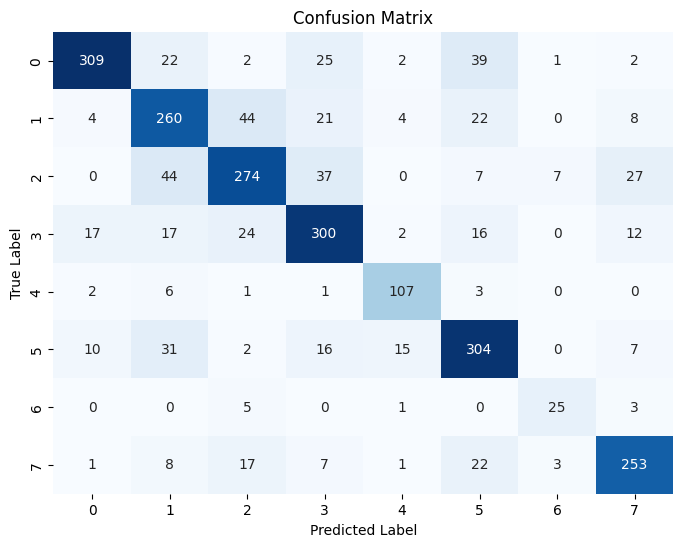

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_numpy, y_pred_numpy)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.unique(y_pred_numpy), yticklabels=np.unique(y_test_numpy))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [40]:
from sklearn.metrics import classification_report

report = classification_report(y_test_numpy, y_pred_numpy)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       402
           1       0.67      0.72      0.69       363
           2       0.74      0.69      0.72       396
           3       0.74      0.77      0.75       388
           4       0.81      0.89      0.85       120
           5       0.74      0.79      0.76       385
           6       0.69      0.74      0.71        34
           7       0.81      0.81      0.81       312

    accuracy                           0.76      2400
   macro avg       0.76      0.77      0.77      2400
weighted avg       0.77      0.76      0.76      2400



#### Wav2vec for classification using Mean Pooling

In [41]:
num_epochs = 50
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in wav2vec_train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(wav2vec_train_loader):.4f}")

Epoch [1/50], Loss: 1.9468
Epoch [2/50], Loss: 1.6817
Epoch [3/50], Loss: 1.5728
Epoch [4/50], Loss: 1.4976
Epoch [5/50], Loss: 1.4217
Epoch [6/50], Loss: 1.3421
Epoch [7/50], Loss: 1.3109
Epoch [8/50], Loss: 1.2679
Epoch [9/50], Loss: 1.2326
Epoch [10/50], Loss: 1.2106
Epoch [11/50], Loss: 1.1676
Epoch [12/50], Loss: 1.1464
Epoch [13/50], Loss: 1.1417
Epoch [14/50], Loss: 1.1183
Epoch [15/50], Loss: 1.1003
Epoch [16/50], Loss: 1.0886
Epoch [17/50], Loss: 1.0727
Epoch [18/50], Loss: 1.0625
Epoch [19/50], Loss: 1.0605
Epoch [20/50], Loss: 1.0387
Epoch [21/50], Loss: 1.0283
Epoch [22/50], Loss: 1.0192
Epoch [23/50], Loss: 1.0152
Epoch [24/50], Loss: 0.9983
Epoch [25/50], Loss: 0.9906
Epoch [26/50], Loss: 0.9851
Epoch [27/50], Loss: 0.9652
Epoch [28/50], Loss: 0.9608
Epoch [29/50], Loss: 0.9531
Epoch [30/50], Loss: 0.9532
Epoch [31/50], Loss: 0.9399
Epoch [32/50], Loss: 0.9244
Epoch [33/50], Loss: 0.9301
Epoch [34/50], Loss: 0.9206
Epoch [35/50], Loss: 0.9090
Epoch [36/50], Loss: 0.9119
E

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()
y_true = [] 
y_pred = []
correct, total = 0, 0

with torch.no_grad():
    for X_batch, y_batch in wav2vec_val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability
        total += y_batch.size(0)
        y_true.extend(y_batch)
        y_pred.extend(predicted)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 62.79%


In [43]:
y_pred_stacked = torch.stack(y_pred)
y_pred_numpy = y_pred_stacked.cpu().numpy()
y_test_stacked = torch.stack(y_true)
y_test_numpy = y_test_stacked.cpu().numpy()

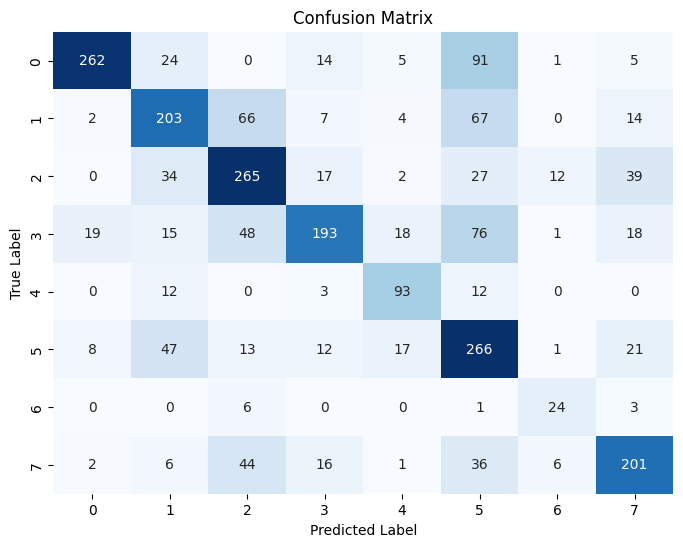

In [44]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_numpy, y_pred_numpy)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.unique(y_pred_numpy), yticklabels=np.unique(y_test_numpy))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [45]:
from sklearn.metrics import classification_report

report = classification_report(y_test_numpy, y_pred_numpy)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.65      0.75       402
           1       0.60      0.56      0.58       363
           2       0.60      0.67      0.63       396
           3       0.74      0.50      0.59       388
           4       0.66      0.78      0.72       120
           5       0.46      0.69      0.55       385
           6       0.53      0.71      0.61        34
           7       0.67      0.64      0.66       312

    accuracy                           0.63      2400
   macro avg       0.64      0.65      0.64      2400
weighted avg       0.66      0.63      0.63      2400

